<a id='sec0'></a>
# UserType Classification without gender field imbalance
- Initial test on user type classification with 'birth year' column removed from the analysis
- Demonstrating large imbalance in the dataset
- This time, all data from 2013 were used
- Test with Multinomial Naive Bayes, Decision Tree, and Random Forest classifiers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from collections import Counter

import my_scoring_functions as msf

%matplotlib inline

# Setting up Data (This time tried to label subscriber as 0)

In [2]:
d2013 = pd.read_csv('../data/for_predictions/2013_membership_pred.csv')
d2014 = pd.read_csv('../data/for_predictions/2014_membership_pred.csv')
d2015 = pd.read_csv('../data/for_predictions/2015_membership_pred.csv')
d2016 = pd.read_csv('../data/for_predictions/2016_membership_pred.csv')
d2017 = pd.read_csv('../data/for_predictions/2017_membership_pred.csv')

In [3]:
all_data = [d2013, d2014, d2015, d2016, d2017]

In [4]:
# Obtained the fraction of non-subscribers
total = 0
total_nonsub = 0
for i in range(len(all_data)):
    year = i + 2013
    d = all_data[i]
    nonsubs_num = len(d[d['usertype'] == 'Customer'])
    total += len(d)
    total_nonsub += nonsubs_num
    print('# Non-subscriber Entries in %d = %d' % (year, nonsubs_num))
print('Total # Non-subscriber Entries = %d (out of %d)' % (total_nonsub, total))
print('%% of Non-subscriber Entries = %f' % (100 * total_nonsub / total))

# Non-subscriber Entries in 2013 = 666940
# Non-subscriber Entries in 2014 = 793495
# Non-subscriber Entries in 2015 = 1311331
# Non-subscriber Entries in 2016 = 1508073
# Non-subscriber Entries in 2017 = 92711
Total # Non-subscriber Entries = 4372550 (out of 39096233)
% of Non-subscriber Entries = 11.184070


In [5]:
all_data = None

In [6]:
# create dataset for classification
data = pd.concat([d2013, d2014, d2015, d2016, d2017], axis=0)
data = data.dropna()

In [7]:
# This time, birth year was not included
data.columns

Index(['tripduration', 'start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude', 'start_year',
       'start_month', 'start_day', 'start_hour', 'start_dayofweek', 'gender',
       'usertype'],
      dtype='object')

In [8]:
data.head()

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,gender,usertype
0,634,40.753231,-73.970325,40.732219,-73.981656,2013,7,1,0,0,0,Customer
1,1547,40.749718,-74.002950,40.746745,-74.007756,2013,7,1,0,0,0,Customer
2,178,40.730287,-73.990765,40.730473,-73.986724,2013,7,1,0,0,2,Subscriber
3,1580,40.718939,-73.992663,40.769155,-73.981918,2013,7,1,0,0,0,Customer
4,757,40.734927,-73.992005,40.720664,-73.985180,2013,7,1,0,0,1,Subscriber


In [9]:
data.describe().round(0)

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,gender
count,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0
mean,920.0,41.0,-74.0,41.0,-74.0,2015.0,7.0,16.0,14.0,3.0,1.0
std,7616.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,5.0,2.0,1.0
min,60.0,0.0,-74.0,0.0,-74.0,2013.0,1.0,1.0,0.0,0.0,0.0
25%,385.0,41.0,-74.0,41.0,-74.0,2014.0,5.0,8.0,10.0,1.0,1.0
50%,623.0,41.0,-74.0,41.0,-74.0,2015.0,8.0,16.0,15.0,3.0,1.0
75%,1042.0,41.0,-74.0,41.0,-74.0,2016.0,10.0,23.0,18.0,4.0,1.0
max,8933552.0,41.0,0.0,41.0,0.0,2017.0,12.0,31.0,23.0,6.0,2.0


In [10]:
# Store name of the features for later use
feature_labels = data.columns[:-1]

In [11]:
# Create X and y for sklearn
X = data[data.columns[:-1]].astype(np.float)
y = (data['usertype'] == 'Customer').values.astype(np.int)

In [12]:
# Clear memory
data = None

<b>Class frequency in the original dataset</b>

In [13]:
print('==== Original Dataset ====')
total_number_rides = len(y)
total_number_subscribers = Counter(y)[0]
total_number_nonsubscribers = Counter(y)[1]
subs_perc = 100*total_number_subscribers / total_number_rides
nonsubs_perc = 100*total_number_nonsubscribers / total_number_rides
original_stats = {'total': total_number_rides, 
                              'numbers': [total_number_subscribers, total_number_nonsubscribers],
                              'percentages': [subs_perc, nonsubs_perc]}
print('Total number of Rides: %d' % total_number_rides)
print('Total number of Rides by Subscribers: %d (%.2f%% of total rides)' % (total_number_subscribers, subs_perc))
print('Total number of Rides by Non-subscribers: %d (%.2f%% of total rides)' % (total_number_nonsubscribers, nonsubs_perc))

==== Original Dataset ====
Total number of Rides: 39096233
Total number of Rides by Subscribers: 34723683 (88.82% of total rides)
Total number of Rides by Non-subscribers: 4372550 (11.18% of total rides)


# Initial classification with NaiveBayes, DecisionTree, and RandomForest

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [15]:
%%time
Xnbc_train = X_train.copy()
Xnbc_test = X_test.copy()
Xnbc_train.iloc[:, [2, 4]] = np.abs(Xnbc_train.iloc[:, [2, 4]])
Xnbc_test.iloc[:, [2, 4]] = np.abs(Xnbc_test.iloc[:, [2, 4]])

nbc = MultinomialNB()
nbc.fit(Xnbc_train, y_train)

CPU times: user 7.14 s, sys: 7.56 s, total: 14.7 s
Wall time: 17.1 s


In [16]:
%%time
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

CPU times: user 5min 59s, sys: 4.24 s, total: 6min 3s
Wall time: 6min 4s


In [17]:
%%time
rfc = RandomForestClassifier(n_jobs=4)
rfc.fit(X_train, y_train)

CPU times: user 30min 15s, sys: 26 s, total: 30min 41s
Wall time: 9min 31s


In [18]:
%%time
nbc_results = msf.score_clf2(nbc, Xnbc_test, y_test, X_train=Xnbc_train, y_train=y_train)

CPU times: user 1min 51s, sys: 25.2 s, total: 2min 17s
Wall time: 2min 6s


In [19]:
%%time
dtc_results = msf.score_clf2(dtc, X_test, y_test, X_train=X_train, y_train=y_train)

CPU times: user 1min 22s, sys: 16.4 s, total: 1min 39s
Wall time: 1min 39s


In [20]:
%%time
rfc_results = msf.score_clf2(rfc, X_test, y_test, X_train=X_train, y_train=y_train)

CPU times: user 3min 59s, sys: 27.9 s, total: 4min 27s
Wall time: 2min 27s


==== Naive Bayes Metrics on Test Set ====
Accuracy: 0.820022
Precision: 0.310895
Recall: 0.500652
F-Score: 0.383589
Brier Score: 0.179452
Average Precision Score: 0.429860
Confusion Matrix:  [[11948153  1941119]
 [  873471   875751]]
==== Naive Bayes Metrics on Train Set ====
Accuracy: 0.820206
Precision: 0.311279
Recall: 0.501185
F-Score: 0.384037
Brier Score: 0.179275
Average Precision Score: 0.430186
Confusion Matrix:  [[17925404  2909007]
 [ 1308556  1314772]]


==== Decision Tree Metrics on Test Set ====
Accuracy: 0.993209
Precision: 0.969353
Recall: 0.969956
F-Score: 0.969655
Brier Score: 0.006790
Average Precision Score: 0.971336
Confusion Matrix:  [[13835631    53641]
 [   52553  1696669]]
==== Decision Tree Metrics on Train Set ====
Accuracy: 0.999999
Precision: 1.000000
Recall: 0.999995
F-Score: 0.999997
Brier Score: 0.000000
Average Precision Score: 1.000000
Confusion Matrix:  [[20834411        0]
 [      14  2623314]]
--------------- Feature Importances ---------------
 1) 

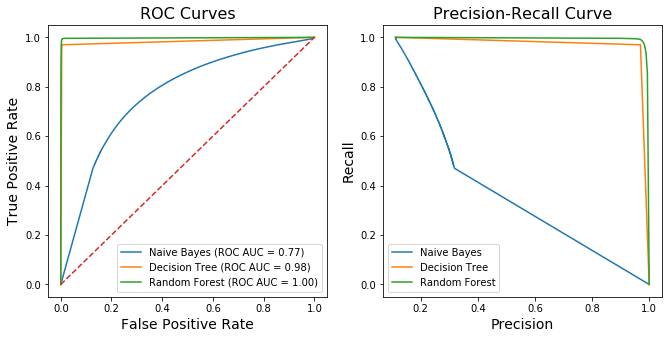

In [22]:
# With newer version with precision-recall curve implemnented
clf_names = ['Naive Bayes', 'Decision Tree', 'Random Forest']
results = [nbc_results, dtc_results, rfc_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

for i in range(len(clf_names)):
    if clf_names[i] == 'Naive Bayes':
        msf.print_clf_scores2(results[i], trainset=True, clf_name=clf_names[i])
    else:
        msf.print_clf_scores2(results[i], trainset=True, clf_name=clf_names[i], feature_labels=feature_labels)
    print('\n')
                               
    fpr = results[i]['scores']['roc_curve'][0]
    tpr = results[i]['scores']['roc_curve'][1]
    roc_auc = results[i]['scores']['roc_auc']
    ax1.plot(fpr, tpr, ls='-', label='%s (ROC AUC = %0.2f)' % (clf_names[i], roc_auc))
    
    # Precision-Recall Curve to be implemented here
    prec = results[i]['scores']['pr_curve'][0]
    rec = results[i]['scores']['pr_curve'][1]      
    ax2.plot(prec, rec, label='%s' % clf_names[i])

x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)                               
ax1.plot(x, y, ls='--')
ax1.set_title('ROC Curves', fontsize=16)
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curve', fontsize=16)
ax2.set_xlabel('Precision', fontsize=14)
ax2.set_ylabel('Recall', fontsize=14)
ax2.legend(loc='lower left')                             

In [23]:
# Create a table fo summarize the results
data_summary = [nbc_results['scores_train'], nbc_results['scores'], 
                                dtc_results['scores_train'], dtc_results['scores'], 
                                rfc_results['scores_train'], rfc_results['scores']]
summary = pd.DataFrame(data_summary)
summary['Classifier'] = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes',
                                           'Decision Tree', 'Decision Tree',
                                           'Rando Forest', 'Rando Forest']
summary['dataset type'] = ['train', 'test', 'train', 'test', 'train', 'test',]
summary = summary[['Classifier', 'dataset type', 'accuracy', 'precision', 'recall', 'f1', 
                                               'average_precision_score', 'brier']]

In [24]:
print('==== Performance of Classifiers ====')
summary

==== Performance of Classifiers ====


,Classifier,dataset type,accuracy,precision,recall,f1,average_precision_score,brier
0,Multinomial Naive Bayes,train,0.820206,0.311279,0.501185,0.384037,0.430186,1.792751e-01
1,Multinomial Naive Bayes,test,0.820022,0.310895,0.500652,0.383589,0.429860,1.794515e-01
2,Decision Tree,train,0.999999,1.000000,0.999995,0.999997,1.000000,2.984090e-07
3,Decision Tree,test,0.993209,0.969353,0.969956,0.969655,0.971336,6.790472e-03
4,Rando Forest,train,0.999669,0.998828,0.998208,0.998518,0.999989,6.545077e-04
5,Rando Forest,test,0.995639,0.976536,0.984670,0.980586,0.993474,3.652144e-03


<b>The reason for near perfect classification by gender is because ~96% of non-subscribers have gender = unknown! Other things only help further refine the classification...</b>